In [60]:
import os
import cv2
import csv
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import CustomObjectScope
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D,MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D


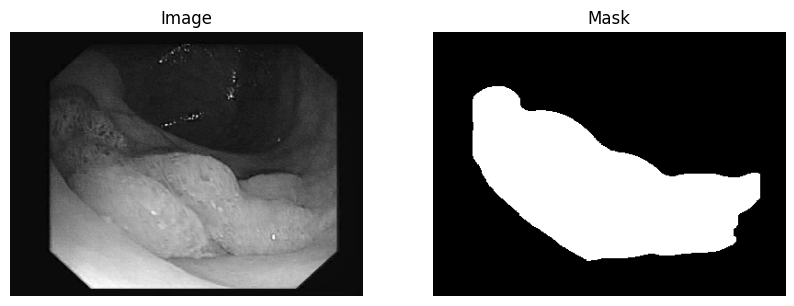

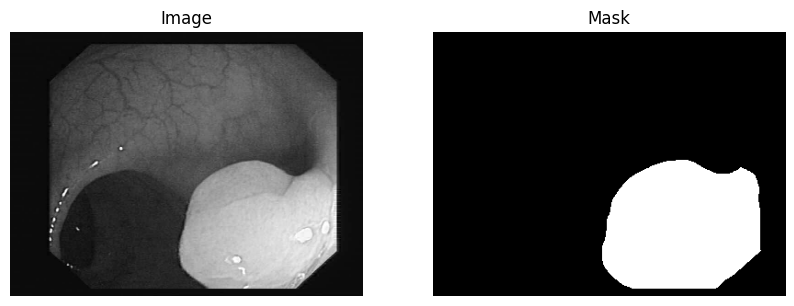

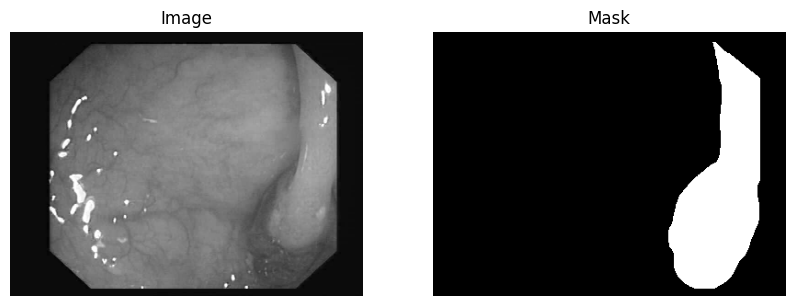

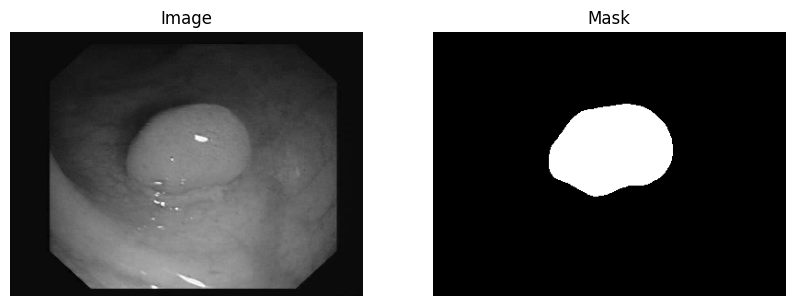

In [30]:
image_dir = "/kaggle/input/cvcclinicdb/CVC-ClinicDB/images/"
mask_dir = "/kaggle/input/cvcclinicdb/CVC-ClinicDB/masks/"

image_files = os.listdir(image_dir)[:4]

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, image_file)

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Image')
    axes[0].axis('off')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

In [3]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=valid_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=valid_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [4]:
path = "/kaggle/input/cvcclinicdb/CVC-ClinicDB"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print(len(train_x), len(valid_x), len(test_x))


490 61 61


In [5]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(256,256))
    x = x/255.0
    return x

In [6]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(256,256))
    x = x/255.0
    x = np.expand_dims(x,axis=-1)
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x,y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x,y = tf.numpy_function(_parse,[x,y],[tf.float64, tf.float64])
    x.set_shape([256,256,3])
    y.set_shape([256,256,1])

    return x,y

In [8]:
def tf_dataset(x, y, batch = 8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [9]:
ds = tf_dataset(test_x, test_y)
for x,y in ds:
    print(x.shape, y.shape)
    break

(8, 256, 256, 3) (8, 256, 256, 1)


In [10]:
train_dataset = tf_dataset(train_x, train_y, batch=8)
valid_dataset = tf_dataset(valid_x, valid_y, batch=8)
test_dataset = tf_dataset(test_x, test_y, batch=8)

for x, y in train_dataset.take(1):
    print(f"train_dataset x shape: {x.shape}, y shape: {y.shape}")

for x, y in valid_dataset.take(1):
    print(f"valid_dataset x shape: {x.shape}, y shape: {y.shape}")

for x, y in test_dataset.take(1):
    print(f"test_dataset x shape: {x.shape}, y shape: {y.shape}")


train_dataset x shape: (8, 256, 256, 3), y shape: (8, 256, 256, 1)
valid_dataset x shape: (8, 256, 256, 3), y shape: (8, 256, 256, 1)
test_dataset x shape: (8, 256, 256, 3), y shape: (8, 256, 256, 1)


# Building U-Net Model

# Model Architecture

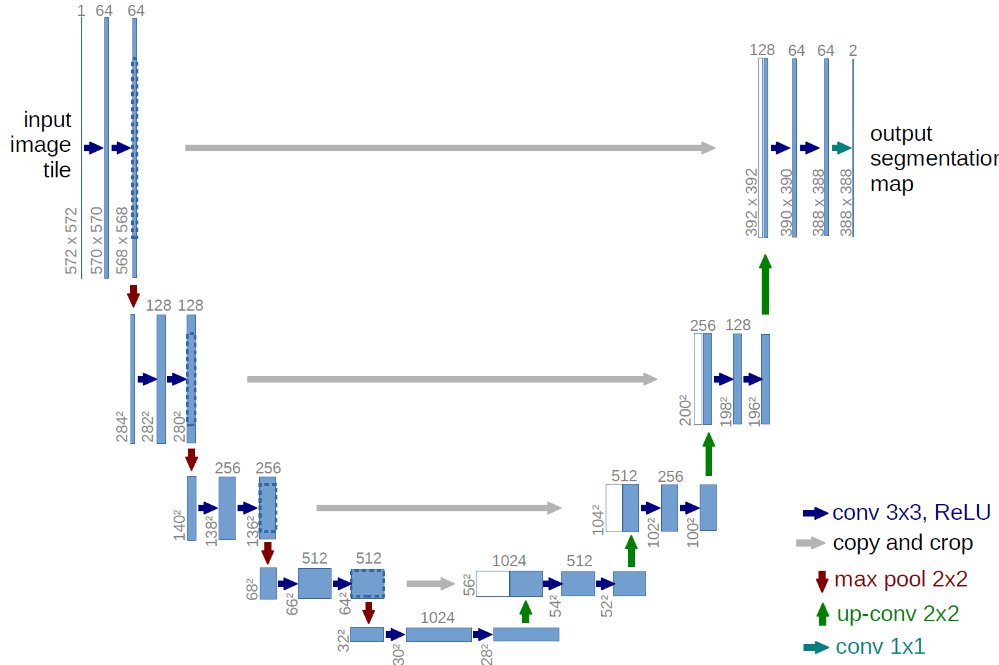

In [12]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [13]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [14]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """ Bridge """
    b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model


In [15]:
np.random.seed(42)
tf.random.set_seed(42)

batch = 8
lr = 1e-4
epochs = 20

In [16]:
unet_model = build_unet((256, 256, 3))

unet_model.compile(loss="binary_crossentropy", optimizer=Adam(lr),metrics=["accuracy",Recall(), Precision()])

In [17]:
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Training Part

In [18]:
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

In [19]:
def create_dir(path):
    try:
        os.makedirs(path, exist_ok=True)
        print(f"Directory '{path}' created successfully")
    except OSError as error:
        print(f"Error creating directory '{path}': {error}")

create_dir("/kaggle/working/notebook_files")

Directory '/kaggle/working/notebook_files' created successfully


In [20]:
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1


In [21]:
print(f"Training steps: {train_steps}, Validation steps: {valid_steps}")


Training steps: 62, Validation steps: 8


In [22]:
csv_file_path = os.path.join("notebook_files", "training_log.csv")
csv_file = open(csv_file_path, "w", newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["epoch", "loss", "accuracy", "recall", "precision", "val_loss", "val_accuracy", "val_recall", "val_precision"])


85

In [23]:
history_dict = {
    'loss': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_recall': [],
    'val_precision': []
}

In [24]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    epoch_history = unet_model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=1,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        verbose=1
    )

    loss = epoch_history.history['loss'][0]
    accuracy = epoch_history.history['accuracy'][0]
    recall = epoch_history.history['recall'][0]
    precision = epoch_history.history['precision'][0]
    val_loss = epoch_history.history['val_loss'][0]
    val_accuracy = epoch_history.history['val_accuracy'][0]
    val_recall = epoch_history.history['val_recall'][0]
    val_precision = epoch_history.history['val_precision'][0]

    csv_writer.writerow([epoch+1, loss, accuracy, recall, precision, val_loss, val_accuracy, val_recall, val_precision])

    history_dict['loss'].append(loss)
    history_dict['accuracy'].append(accuracy)
    history_dict['recall'].append(recall)
    history_dict['precision'].append(precision)
    history_dict['val_loss'].append(val_loss)
    history_dict['val_accuracy'].append(val_accuracy)
    history_dict['val_recall'].append(val_recall)
    history_dict['val_precision'].append(val_precision)

    
csv_file.close()

Epoch 1/20


2024-06-03 13:05:36.993577: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.72144, expected 2.89031
2024-06-03 13:05:36.993634: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.65806, expected 4.82693
2024-06-03 13:05:36.993643: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.98376, expected 5.15263
2024-06-03 13:05:36.993651: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.6283, expected 5.79717
2024-06-03 13:05:36.993659: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.90088, expected 6.06975
2024-06-03 13:05:36.993667: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.70007, expected 5.86894
2024-06-03 13:05:36.993674: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.75339, expected 4.92226
2024-06-03 13:05:36.993682: E external/local_xla/xla/ser

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8148 - loss: 0.4501 - precision: 0.1543 - recall: 0.2042

2024-06-03 13:06:26.399306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.25729, expected 2.60868
2024-06-03 13:06:26.399361: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.51493, expected 2.86632
2024-06-03 13:06:26.399371: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.30991, expected 3.6613
2024-06-03 13:06:26.399378: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.61844, expected 3.96984
2024-06-03 13:06:26.399386: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.70488, expected 4.05627
2024-06-03 13:06:26.399394: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.11794, expected 4.46933
2024-06-03 13:06:26.399402: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.56915, expected 3.92054
2024-06-03 13:06:26.399410: E external/local_xla/xla/ser

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8158 - loss: 0.4486 - precision: 0.1544 - recall: 0.2021

2024-06-03 13:06:44.639895: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65364: 2.53678, expected 2.17699
2024-06-03 13:06:44.639950: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65380: 2.56388, expected 2.20409
2024-06-03 13:06:44.639966: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65381: 2.54569, expected 2.1859
2024-06-03 13:06:44.639984: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65482: 2.57729, expected 2.2175
2024-06-03 13:06:44.640433: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131072: 3.63821, expected 2.67835
2024-06-03 13:06:44.640459: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131073: 5.0582, expected 4.09834
2024-06-03 13:06:44.640476: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131074: 5.50194, expected 4.54208
2024-06-03 13:06:44.640493:

62/62 ━━━━━━━━━━━━━━━━━━━━ 89s 647ms/step - accuracy: 0.8167 - loss: 0.4471 - precision: 0.1545 - recall: 0.2000 - val_accuracy: 0.9104 - val_loss: 0.5623 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.9079 - loss: 0.2549 - precision: 0.5262 - recall: 0.0972 - val_accuracy: 0.9124 - val_loss: 0.3971 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.9136 - loss: 0.2303 - precision: 0.5827 - recall: 0.2614 - val_accuracy: 0.4620 - val_loss: 0.7119 - val_precision: 0.1381 - val_recall: 0.9719
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.9179 - loss: 0.2154 - precision: 0.6102 - recall: 0.3267 - val_accuracy: 0.6085 - val_loss: 0.6568 - val_precision: 0.1530 - val_recall: 0.7574
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9228 - loss: 0.2029 - precision: 0.6535 - recall: 0.3707 - val_accuracy: 0.7999 - va

In [25]:
unet_model.save(os.path.join("/kaggle/working/notebook_files", "final_model.keras"))

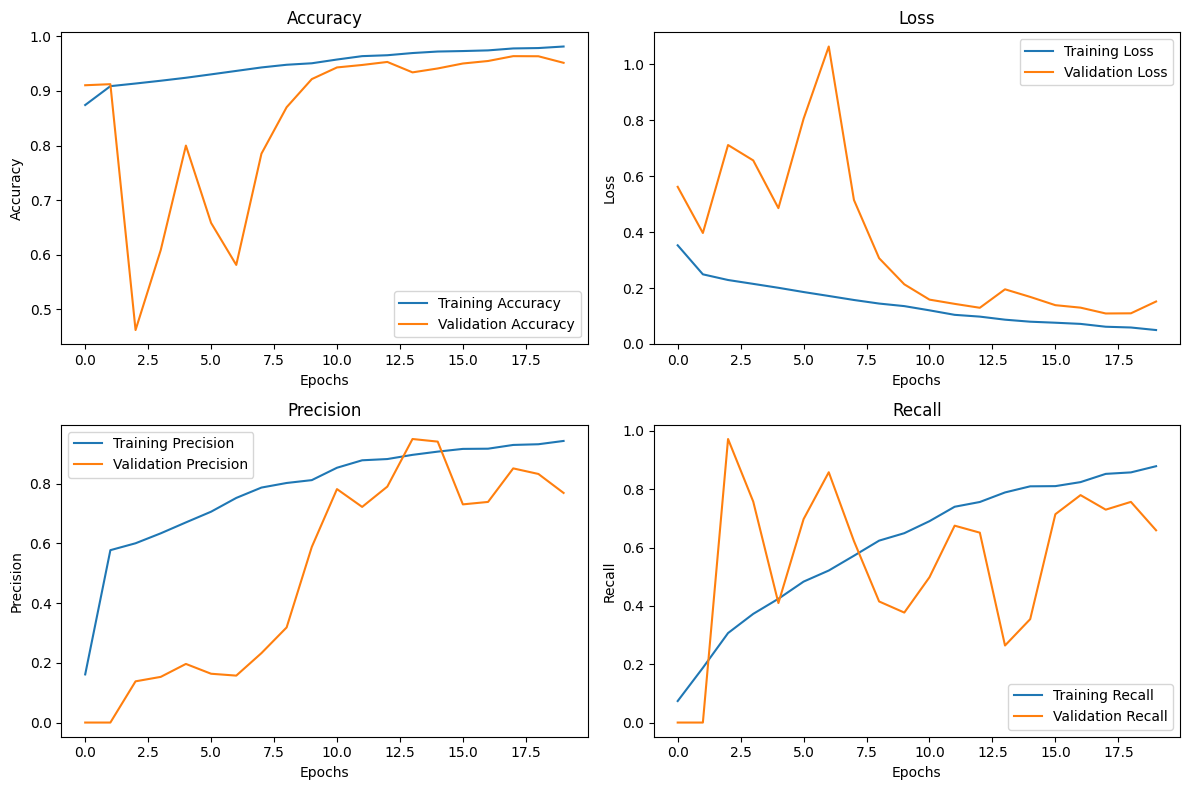

In [26]:
plt.figure(figsize=(12, 8))
    
    
plt.subplot(2, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

    
plt.subplot(2, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(history_dict['precision'], label='Training Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()


plt.subplot(2, 2, 4)
plt.plot(history_dict['recall'], label='Training Recall')
plt.plot(history_dict['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


# Model Prediction

In [50]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    ori_x = x
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    ori_x = x
    x = x / 255.0
    x = x.astype(np.int32)
    return ori_x, x

In [51]:
def save_results(ori_x, ori_y, y_pred, save_img_path):
    line = np.ones((ori_x.shape[0], 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    cat_image = np.concatenate([ori_x, line, ori_y, line, y_pred * 255], axis=1)
    cv2.imwrite(save_img_path, cat_image)

In [56]:
SCORE = []

In [63]:
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    name = os.path.splitext(os.path.basename(x))[0]

    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    y_pred = unet_model.predict(x)[0] > 0.5
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred.astype(np.int32)

    save_img_path = f"/kaggle/working/results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_img_path)

    y = y.flatten()
    y_pred = y_pred.flatten()

    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

  0%|          | 0/61 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 1/61 [00:00<00:10,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 2/61 [00:00<00:10,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 3/61 [00:00<00:10,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 4/61 [00:00<00:10,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 5/61 [00:00<00:10,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 10%|▉         | 6/61 [00:01<00:09,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█▏        | 7/61 [00:01<00:09,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 8/61 [00:01<00:09,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 15%|█▍        | 9/61 [00:01<00:08,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▋        | 10/61 [00:01<00:08,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 18%|█▊        | 11/61 [00:01<00:08,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 12/61 [00:02<00:08,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██▏       | 13/61 [00:02<00:08,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 14/61 [00:02<00:08,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▍       | 15/61 [00:02<00:08,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 16/61 [00:02<00:07,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 17/61 [00:02<00:07,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 18/61 [00:03<00:07,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███       | 19/61 [00:03<00:07,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 20/61 [00:03<00:07,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 21/61 [00:03<00:07,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 22/61 [00:03<00:07,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 23/61 [00:04<00:07,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 24/61 [00:04<00:07,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 25/61 [00:04<00:07,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 26/61 [00:04<00:06,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 27/61 [00:04<00:06,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 28/61 [00:05<00:06,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 29/61 [00:05<00:05,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 30/61 [00:05<00:05,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 31/61 [00:05<00:05,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 32/61 [00:05<00:05,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 33/61 [00:05<00:05,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 34/61 [00:06<00:04,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 35/61 [00:06<00:04,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 59%|█████▉    | 36/61 [00:06<00:04,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 37/61 [00:06<00:04,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 38/61 [00:06<00:04,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████▍   | 39/61 [00:07<00:03,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 40/61 [00:07<00:03,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 41/61 [00:07<00:03,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 69%|██████▉   | 42/61 [00:07<00:03,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 70%|███████   | 43/61 [00:07<00:02,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 72%|███████▏  | 44/61 [00:07<00:02,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 45/61 [00:08<00:02,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▌  | 46/61 [00:08<00:02,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 47/61 [00:08<00:02,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▊  | 48/61 [00:08<00:02,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 49/61 [00:08<00:02,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 50/61 [00:08<00:01,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▎ | 51/61 [00:09<00:01,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▌ | 52/61 [00:09<00:01,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 53/61 [00:09<00:01,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 54/61 [00:09<00:01,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|█████████ | 55/61 [00:09<00:01,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 56/61 [00:10<00:00,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 57/61 [00:10<00:00,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 58/61 [00:10<00:00,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 59/61 [00:10<00:00,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 60/61 [00:10<00:00,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 61/61 [00:10<00:00,  5.59it/s]


In [64]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")


Accuracy: 0.94052
F1: 0.55769
Jaccard: 0.44812
Recall: 0.60501
Precision: 0.61600


In [65]:
df = pd.DataFrame(SCORE, columns=["Image Name", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("/kaggle/working/notebook_files/score.csv")

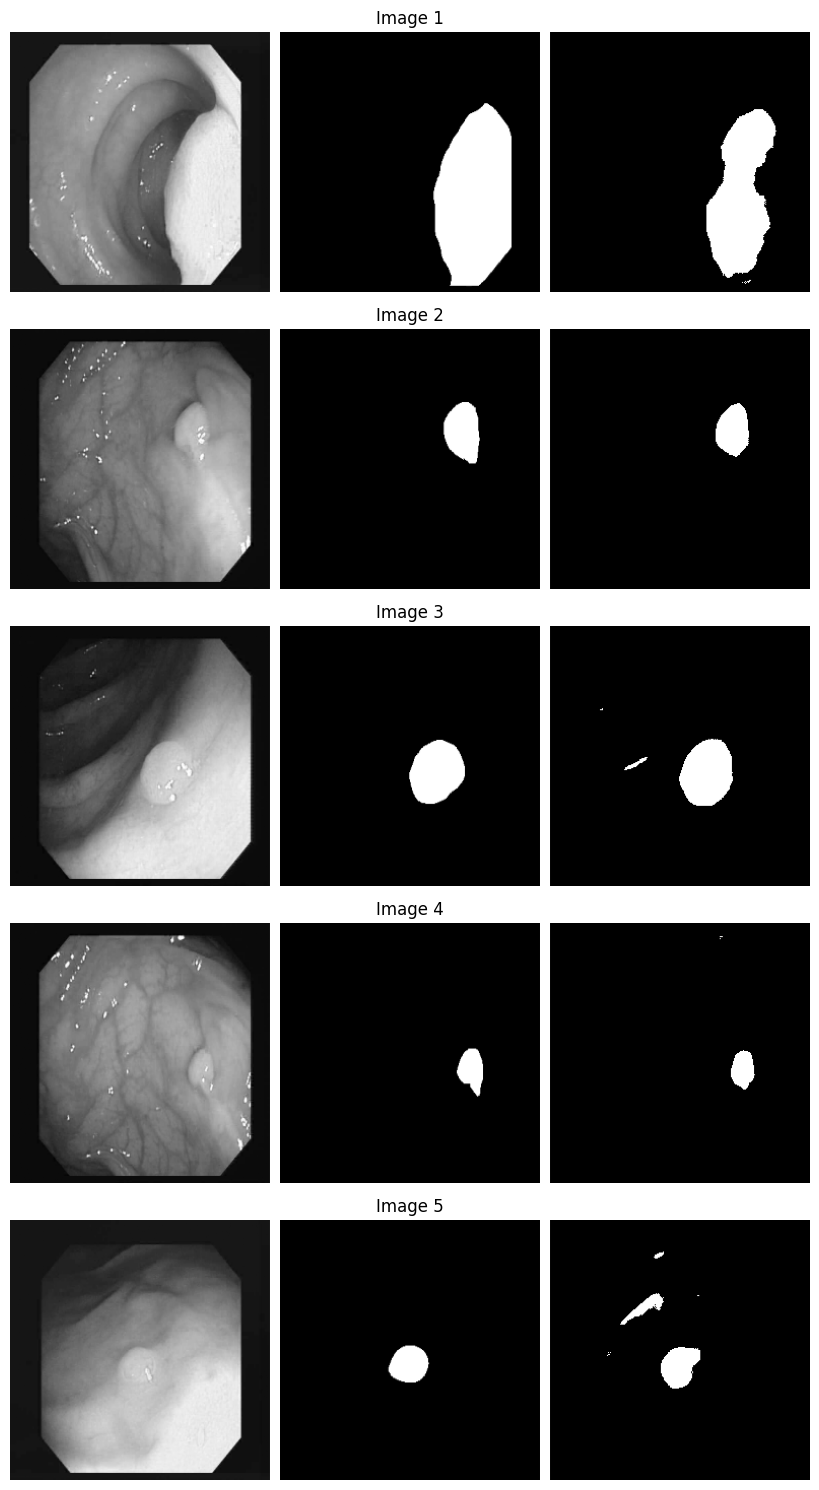

In [74]:
result_dir = "/kaggle/working/results"

image_files = [f for f in os.listdir(result_dir) if f.endswith(".png")]

fig, axes = plt.subplots(5, 1, figsize=(30, 15))

for i, image_file in enumerate(image_files[25:30]):
    image_path = os.path.join(result_dir, image_file)
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()